In [456]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
np.warnings.filterwarnings('ignore')

from tqdm import tqdm
import pandas as pd


split_color = 'tomato'
local_color = 'gray'
cqr_color = 'lightblue'

%matplotlib inline
np.random.seed(1)

# desired miscoverage error
alpha = 0.1
# low and high target quantiles
quantiles = [5, 95]

# maximal number of testpoints to plot
max_show = 1000

# save figures?
save_figures = False

# parameters of random forests
n_estimators = 100
min_samples_leaf = 40
max_features = 1 # 1D signal
random_state = 0

In [509]:
def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title="",
              filename=None,
              save_figures=False):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    x : numpy array, corresponding to the feature of each of the n samples
    y : numpy array, target response variable (length n)
    pred : numpy array, the estimated prediction. It may be the conditional mean,
           or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """
    
    x_ = x[:max_show]
    y_ = y[:max_show]
    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]
    if pred is not None:
        pred_ = pred[:max_show]

    fig = plt.figure(figsize=(7,5))
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds,:], y_[inds], 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                 np.concatenate([y_u_[inds], y_l_[inds][::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' prediction set')
    
    if pred is not None:
        if pred_.ndim == 2:
            plt.plot(x_[inds,:], pred_[inds,0], 'k', lw=2, alpha=0.9),
                     #label=u'Predicted low and high quantiles')
            plt.plot(x_[inds,:], pred_[inds,1], 'k', lw=2, alpha=0.9)
        else:
            plt.plot(x_[inds,:], pred_[inds], 'k--', lw=2, alpha=0.9,
                     label=u'Predicted value')
    
    plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()
    return fig

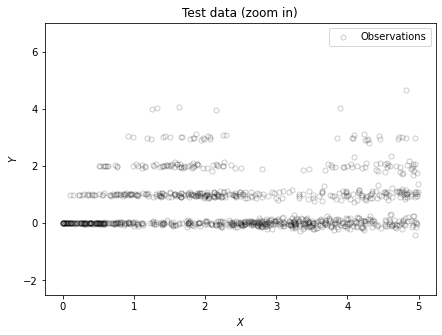

In [510]:
# number of training examples
n_train = 2000
# number of test examples (to evaluate average coverage and length)
n_test = 5000

def f(x):
    ''' Construct data (1D example)
    '''
    ax = 0*x
    for i in range(len(x)):
        ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
        ax[i] += 25*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
    return ax.astype(np.float32)

# training features
x_train = np.random.uniform(0, 5.0, size=n_train).astype(np.float32)

# test features
x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

# generate labels
y_train = f(x_train)
y_test = f(x_test)

# reshape the features
x_train = np.reshape(x_train,(n_train,1))
x_test = np.reshape(x_test,(n_test,1))

# display the test data in full range (including the outliers)
# fig = plt.figure()
# plt.plot(x_test, y_test, 'k.', alpha = 0.3, markersize=10,
#          fillstyle='none', label=u'Observations')
# plt.legend()
# plt.xlabel('$X$')
# plt.ylabel('$Y$')
# plt.title('Test data (visualize outliers)')
# if save_figures:
#     plt.savefig("illustration_test_data.png",
#                 bbox_inches='tight', dpi=300)

# display the test data without outliers (zoom in)
_ = plot_func(x_test,y_test,title="Test data (zoom in)")

# divide the data into proper training set and calibration set

idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

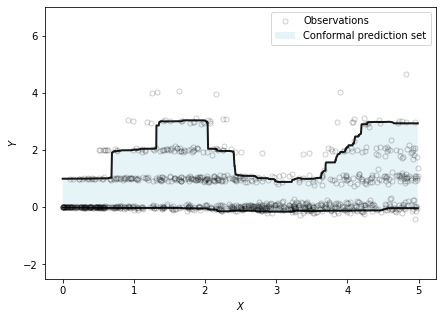

CQR Random Forests: Percentage in the range (expecting 90.0%): 90.34
CQR Random Forests: Average length: 2.0725093701887447


In [511]:
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import QuantileRegErrFunc

import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
    
# define quantile random forests (QRF) parameters
params_qforest = dict()
params_qforest["n_estimators"] = n_estimators
params_qforest["min_samples_leaf"] = min_samples_leaf
params_qforest["max_features"] = max_features
params_qforest["CV"] = True
params_qforest["coverage_factor"] = 0.9
params_qforest["test_ratio"] = 0.1
params_qforest["random_state"] = random_state
params_qforest["range_vals"] = 10
params_qforest["num_vals"] = 4

# define the QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles,
                                                           params=params_qforest)

# define the CQR object, computing the absolute residual error of points 
# located outside the estimated QRF band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# build the split CQR object
icp = IcpRegressor(nc)

# fit the conditional quantile regression to the proper training data
icp.fit(x_train[idx_train], y_train[idx_train])

# compute the absolute errors on calibration data
icp.calibrate(x_train[idx_cal], y_train[idx_cal])

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the low and high conditional quantile estimation
pred = quantile_estimator.predict(x_test)

# display the results
plot_func(x=x_test,y=y_test,y_u=y_upper,y_l=y_lower,pred=pred,shade_color=cqr_color,
          method_name="Conformal",title="",
          filename="illustration_split_qrf.png",save_figures=False)

# compute and display the average coverage
coverage = (y_test >= y_lower) & (y_test <= y_upper)
in_the_range = np.sum(coverage)
print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test) * 100)

# compute length of the conformal interval per each test point
length_cqr_rf = y_upper - y_lower

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

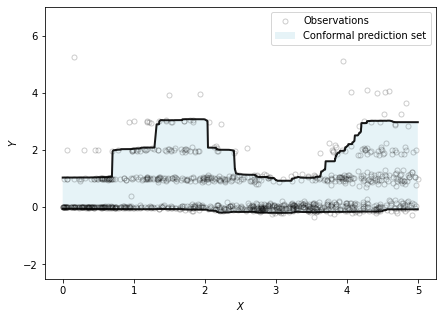

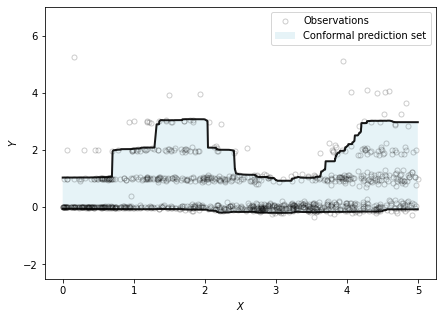

In [609]:
predictions = icp.predict(x_test, significance=alpha)
y_lower = predictions[:,0]
y_upper = predictions[:,1]

plot_func(x=x_test,y=y_test,y_u=y_upper,y_l=y_lower,pred=predictions,shade_color=cqr_color,
          method_name="Conformal",title="",
          filename="illustration_split_qrf.png",save_figures=True)

In [512]:
# audit validation data

n_oos = 50000
x_oos = np.random.uniform(0, 5.0, size=n_oos).astype(np.float32)
y_oos = f(x_oos)

x_oos = x_oos.reshape(n_oos, 1)

predictions_oos = icp.predict(x_oos, significance=alpha)
coverage_oos = (y_oos >= predictions_oos[:,0]) & (y_oos <= predictions_oos[:,1])
oos_df = pd.DataFrame(dict(x = x_oos.flatten(), coverage = coverage_oos))

In [569]:
sort_idx = np.argsort(x_oos.flatten())
x_oos = x_oos[sort_idx].flatten()
coverage_oos = coverage_oos[sort_idx]

num_chunks = int(5 / 0.1)

chunk_vals = np.zeros((num_chunks, 2))
g = np.ones_like(coverage_oos)

for i, start in enumerate(np.linspace(0, 4.9, num_chunks)):
    idx = np.where((x_oos >= start) & (x_oos <= start + 0.1))
    chunk_vals[i,0] = np.sum(g[idx]) 
    chunk_vals[i,1] = np.sum(coverage_oos[idx])
    
num_sets = int((num_chunks * (num_chunks + 1))/2)
oos_df = np.empty((num_sets,2))

oos_df[:,1] = np.arange(num_scores)

idx = 0

for i, start in enumerate(np.linspace(0, 4.9, num_chunks)):
    i_sums = np.cumsum(chunk_vals[i:num_chunks,], axis=0)
    group_cov = i_sums[:,1] / i_sums[:,0]

    oos_df[idx:idx + len(i_sums),0] = group_cov
    idx += len(i_sums)
    
oos_df = pd.DataFrame(oos_df, columns=['coverage', 'interval'])

## Confidence bounds on coverage

In [754]:
def sample_ci_score(x, coverage, rng, boot_index):
    sort_idx = np.argsort(x.flatten())
    x = x[sort_idx].flatten()
    L = ~coverage[sort_idx]
    
    n = len(x)
    w = rng.multinomial(n, [1/n] * n, size=1).flatten()
    
    g = np.ones_like(x) / n
    wg = w / n
    wL = (w * L) / n
    L = L / n
    
    num_chunks = int(5 / 0.1)
    chunk_vals = np.zeros((num_chunks, 4))
    
    
    for i, start in enumerate(np.linspace(0, 4.9, num_chunks)):
        idx = np.where((x >= start) & (x <= start + 0.1))
        chunk_vals[i,0] = np.sum(g[idx]) 
        chunk_vals[i,1] = np.sum(wL[idx])
        chunk_vals[i,2] = np.sum(L[idx])
        chunk_vals[i,3] = np.sum(wg[idx])
    
    num_scores = int((num_chunks * (num_chunks + 1))/2)
    score_df = np.empty((num_scores,7))
    score_df[:,3] = np.arange(num_scores)
    score_df[:,4] = boot_index
    
    idx = 0
    
    for i, start in enumerate(np.linspace(0, 4.9, num_chunks)):
        i_sums = np.cumsum(chunk_vals[i:num_chunks,], axis=0)
        scores = i_sums[:,0] * i_sums[:,1] - i_sums[:,2] * i_sums[:,3]
        
        score_df[idx:idx + len(i_sums),0] = scores
        score_df[idx:idx + len(i_sums),1] = start
        score_df[idx:idx + len(i_sums),2] = np.linspace(start + 0.1, 5, len(i_sums))
        score_df[idx:idx + len(i_sums),5] = 1 - i_sums[:,2] / i_sums[:,0]
        score_df[idx:idx + len(i_sums),6] = i_sums[:,0]
        idx += len(i_sums)   
        
    return score_df


In [721]:
rng = np.random.default_rng(seed=0)

num_chunks = int(5 / 0.1)
num_scores = int((num_chunks * (num_chunks + 1))/2)

B = 500
score_df = np.zeros((B * num_scores, 7))
idx = 0
for b in tqdm(range(B)):
    score_df[idx:(idx + num_scores),] = sample_ci_score_t(x_test, coverage, rng, b)
    idx += num_scores
    
# trim = 1e-8# 1e-4

score_df = pd.DataFrame(score_df, columns=['score', 'start', 'end', 'interval', 'boot', 'empirical', 'P_G'])

score_df['s_g'] = score_df.groupby("interval")['score'].transform(scipy.stats.median_abs_deviation)

trim = score_df['s_g'].quantile(0.3)
score_df['s_g'] = score_df['s_g'].clip(trim)
score_df['score_scaled'] = score_df['score'] / score_df['s_g']
score_df['length'] = score_df['end'] - score_df['start']
score_df

100%|██████████| 500/500 [00:02<00:00, 199.59it/s]


,score,start,end,interval,boot,empirical,P_G,length
0,0.014295,0.0,0.1,0.0,0.0,0.983193,0.0238,0.1
1,0.015476,0.0,0.2,1.0,0.0,0.990654,0.0428,0.2
2,0.006658,0.0,0.3,2.0,0.0,0.986111,0.0576,0.3
3,0.007315,0.0,0.4,3.0,0.0,0.977099,0.0786,0.4
4,0.008737,0.0,0.5,4.0,0.0,0.973361,0.0976,0.5
...,...,...,...,...,...,...,...,...
637495,0.012385,4.7,4.9,1270.0,499.0,0.847291,0.0406,0.2
637496,0.011937,4.7,5.0,1271.0,499.0,0.827362,0.0614,0.3
637497,0.007204,4.8,4.9,1272.0,499.0,0.857143,0.0224,0.1
637498,0.006706,4.8,5.0,1273.0,499.0,0.824074,0.0432,0.2


In [515]:
import scipy.stats

# compute critical value


def query_coverage(start_val, end_val, test_df):
    G_filter = (test_df['x'] <= end_val) & (test_df['x'] >= start_val)
    p_G = G_filter.sum() / len(test_df)
    
    emp_coverage = test_df.loc[G_filter, 'coverage'].mean()
    return emp_coverage, p_G

# get upper confience bound for given interval
def query_bound(start_val, end_val, test_df, boot_df, t, scaled=False):
    emp_coverage, p_G = query_coverage(start_val, end_val, test_df)
    
    if scaled:
        G_filter = np.isclose(boot_df['start'],start_val) & np.isclose(boot_df['end'], end_val)
        s_G = boot_df.loc[G_filter, 's_g'].max()
    else:
        s_G = 1
    return emp_coverage, emp_coverage + (s_G * t) / p_G**2


(0.9225280326197758, 0.8987383506043047)
(0.9225280326197758, 0.7351385441530955)


In [516]:
# compute critical value
t_s = score_df.groupby('boot')['score_scaled'].min().quantile(0.05)
t = score_df.groupby('boot')['score'].min().quantile(0.05)


print(query_bound(0., 1, test_df, score_df, t_s, scaled=True))
print(query_bound(0., 1, test_df, score_df, t, scaled=False))
# query all bounds on test_df and query all coverages on oos_df

test_df = pd.DataFrame(dict(x=x_test.flatten(), coverage=coverage))
bools = []
for start in np.linspace(0, 4.9, num_chunks):
    num_to_end = int(np.round((5 - start) / 0.1))
    for end in np.linspace(start + 0.1, 5, num_to_end):
        _, bound = query_bound(start, end, test_df, score_df, t_s, scaled=True)
        truth, _ = query_coverage(start, end, oos_df)
        bools.append(bound <= truth)
        
print(np.mean(bools))

1.0


In [ ]:
def compute_bound(score_df, idx, method, trim_prob):
    score_df[f's_g_{idx}'] = compute_student(score_df, method, trim_prob)
    score_df['score_scaled'] = score_df['score'] / score_df[f's_g_{idx}']
    t_s = score_df.groupby('boot')['score_scaled'].min().quantile(0.05)
    score_df[f'bound_{idx}'] = score_df['empirical'] + (t_s * score_df[f's_g_{idx}']) / score_df['P_G']**2
    score_df[f'bound_{idx}'] = score_df[f'bound_{idx}'].clip(0)
    return score_df

def compute_student(score_df, method, trim_prob):
    if method == "prob":
        students = score_df["P_G"]**(3/2)
    elif method == "mad":
        students = score_df.groupby("interval")['score'].transform(scipy.stats.median_abs_deviation)
    elif method == "iqr":
        students = score_df.groupby("interval")['score'].transform(scipy.stats.iqr)
    elif method == 'width':
        students = ((score_df['end'] - score_df['start']) / 5)**(3/2)
    else:
        students = np.ones((len(score_df,)))
    students[score_df['P_G'] < trim_prob] = 1
    students[students == 0] += 1
    return students

def run_trial(seed, n_test, methods, trim_probs):
    np.random.seed(seed)
    x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

    # generate labels
    y_test = f(x_test)

    # reshape the features
    x_test = np.reshape(x_test,(n_test,1))

    predictions = icp.predict(x_test, significance=alpha)
    y_lower = predictions[:,0]
    y_upper = predictions[:,1]

    coverage = (y_test >= y_lower) & (y_test <= y_upper)

    rng = np.random.default_rng(seed=0)

    num_chunks = int(5 / 0.1)
    num_scores = int((num_chunks * (num_chunks + 1))/2)

    B = 1000
    score_df = np.zeros((B * num_scores, 7))
    idx = 0
    for b in range(B):
        score_df[idx:(idx + num_scores),] = sample_ci_score(x_test, coverage, rng, b)
        idx += num_scores

    score_df = pd.DataFrame(score_df, columns=['score', 'start', 'end', 'interval', 'boot', 'empirical', 'P_G'])
    score_df['length'] = score_df['end'] - score_df['start']

    bound_idx = 0
    for method in methods:
        for trim in trim_probs:
            score_df = compute_bound(score_df, bound_idx, method, trim)
            bound_idx += 1
            
    comp_df = score_df.merge(oos_df, on=['interval'])
    fwer = np.empty((len(methods) * len(trim_probs),))
    for j in range(bound_idx):
        fwer[j] = (comp_df[f'bound_{j}'] < comp_df['coverage']).all()
            
    return fwer, comp_df

n_trials = 500
n_test = 2000
methods = ['prob', 'width', 'none']
trim_probs = [0, 25 / n_test, 0.05]

fwer_array = np.empty((n_trials, len(methods) * len(trim_probs)),)
for trial in tqdm(range(n_trials)):
    fwer, score_df = run_trial(trial + 2000000, n_test, methods, trim_probs)
    fwer_array[trial,] = fwer
    if trial % 10 == 0:
        print(np.mean(fwer_array[0:(trial+1),:], axis=0))
    
    

  0%|          | 1/500 [00:09<1:18:04,  9.39s/it]

[1. 1. 1. 1. 1. 1. 1. 1. 1.]


  2%|▏         | 11/500 [01:21<53:43,  6.59s/it] 

[1.         1.         1.         1.         1.         1.
 0.90909091 0.90909091 0.90909091]


  4%|▍         | 21/500 [02:27<51:29,  6.45s/it]

[0.95238095 0.95238095 0.95238095 0.9047619  0.9047619  0.95238095
 0.85714286 0.85714286 0.85714286]


  6%|▌         | 31/500 [03:31<50:36,  6.47s/it]

[0.96774194 0.96774194 0.93548387 0.93548387 0.93548387 0.90322581
 0.90322581 0.90322581 0.90322581]


  8%|▊         | 41/500 [04:36<49:27,  6.47s/it]

[0.92682927 0.92682927 0.85365854 0.87804878 0.87804878 0.85365854
 0.82926829 0.82926829 0.82926829]


 10%|█         | 51/500 [05:41<48:50,  6.53s/it]

[0.94117647 0.94117647 0.88235294 0.88235294 0.88235294 0.88235294
 0.8627451  0.8627451  0.8627451 ]


 12%|█▏        | 61/500 [06:46<47:50,  6.54s/it]

[0.91803279 0.91803279 0.86885246 0.90163934 0.90163934 0.8852459
 0.86885246 0.86885246 0.86885246]


 14%|█▍        | 71/500 [07:52<47:06,  6.59s/it]

[0.92957746 0.92957746 0.88732394 0.91549296 0.91549296 0.88732394
 0.88732394 0.88732394 0.88732394]


 16%|█▌        | 81/500 [09:00<46:23,  6.64s/it]

[0.9382716  0.9382716  0.88888889 0.91358025 0.91358025 0.87654321
 0.87654321 0.87654321 0.87654321]


 18%|█▊        | 91/500 [10:05<43:59,  6.45s/it]

[0.93406593 0.93406593 0.87912088 0.9010989  0.9010989  0.85714286
 0.86813187 0.86813187 0.86813187]


 20%|██        | 101/500 [11:10<44:37,  6.71s/it]

[0.94059406 0.94059406 0.89108911 0.91089109 0.91089109 0.87128713
 0.88118812 0.88118812 0.88118812]


 22%|██▏       | 111/500 [12:31<51:02,  7.87s/it]

[0.94594595 0.94594595 0.9009009  0.91891892 0.91891892 0.88288288
 0.87387387 0.87387387 0.87387387]


 24%|██▍       | 121/500 [13:37<42:07,  6.67s/it]

[0.95041322 0.95041322 0.89256198 0.91735537 0.91735537 0.88429752
 0.87603306 0.87603306 0.87603306]


 26%|██▌       | 131/500 [14:42<39:51,  6.48s/it]

[0.94656489 0.94656489 0.89312977 0.90839695 0.90839695 0.8778626
 0.8778626  0.8778626  0.8778626 ]


 28%|██▊       | 141/500 [15:48<38:57,  6.51s/it]

[0.94326241 0.94326241 0.90070922 0.89361702 0.89361702 0.87234043
 0.88652482 0.88652482 0.88652482]


 30%|███       | 151/500 [16:53<38:42,  6.66s/it]

[0.94701987 0.94701987 0.90728477 0.89403974 0.89403974 0.87417219
 0.88741722 0.88741722 0.88741722]


 32%|███▏      | 161/500 [18:02<40:15,  7.13s/it]

[0.9378882  0.9378882  0.90062112 0.88198758 0.88198758 0.86335404
 0.88819876 0.88819876 0.88819876]


 33%|███▎      | 165/500 [18:33<41:49,  7.49s/it]

In [841]:
np.mean(fwer_array, axis=0)


array([0.956, 0.948, 0.928, 0.934, 0.926, 0.912, 0.934, 0.934, 0.934])

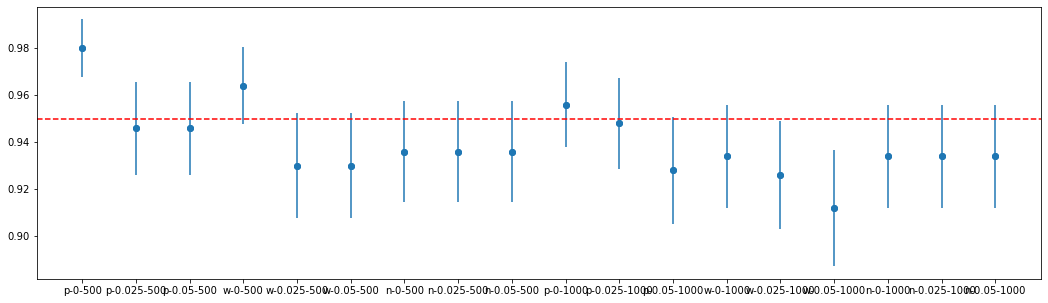

In [855]:
# cell containing good run

import matplotlib.pyplot as plt

for n in [500, 1000]:
    xs = [f'{method[0]}-{trim}'
          for method in methods 
          for trim in trim_probs
         ]
    # ys = np.mean(fwer_500, axis=0)
    ys = np.concatenate((
        np.mean(fwer_500, axis=0), 
        np.mean(fwer_1000, axis=0
    )))
    plt.figure(figsize=(18,5))
    plt.scatter(xs, ys)
    plt.errorbar(xs, 
                ys,
                1.96 * np.sqrt(ys * (1 - ys)) / np.sqrt(500),
                fmt='o')
    plt.axhline(0.95, color='red', linestyle='--')



In [636]:
# x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

# # generate labels
# y_test = f(x_test)

# # reshape the features
# x_test = np.reshape(x_test,(n_test,1))

# predictions = icp.predict(x_test, significance=alpha)
# y_lower = predictions[:,0]
# y_upper = predictions[:,1]

# coverage = (y_test >= y_lower) & (y_test <= y_upper)

rng = np.random.default_rng(seed=0)

num_chunks = int(5 / 0.1)
num_scores = int((num_chunks * (num_chunks + 1))/2)

B = 1000
score_df = np.zeros((B * num_scores, 7))
idx = 0
for b in range(B):
    score_df[idx:(idx + num_scores),] = sample_ci_score(x_test, coverage, rng, b)
    idx += num_scores

score_df = pd.DataFrame(score_df, columns=['score', 'start', 'end', 'interval', 'boot', 'empirical', 'P_G'])

#     score_df['s_g'] = score_df.groupby("interval")['score'].transform(scipy.stats.median_abs_deviation)
score_df['s_g'] = score_df['P_G']**(3/2)

trim = 0.1 ** (3/2) # score_df['s_g'].quantile(0.3)
# score_df['s_g'] = score_df['s_g'].clip(trim)
score_df['score_scaled'] = score_df['score'] / score_df['s_g']
score_df['length'] = score_df['end'] - score_df['start']

# compute critical value
t_s = score_df.groupby('boot')['score_scaled'].min().quantile(0.05)
t = score_df.groupby('boot')['score'].min().quantile(0.05)

score_df['bound_student'] = score_df['empirical'] + (t_s * score_df['s_g']) / score_df['P_G']**2
score_df['bound_student'] = score_df['bound_student'].clip(0)

score_df['bound'] = score_df['empirical'] + (t) / score_df['P_G']**2
score_df['bound'] = score_df['bound'].clip(0)

comp_df = score_df.merge(oos_df, on=['interval'])



In [685]:
coverage_ci_df = pd.DataFrame(dict(student=student, unstudent=unstudent))

coverage_ci_df = coverage_ci_df.melt()
coverage_ci_df
plt.scatter(['student', 'unstudent'], np.mean(student), np.mean(unstudent))
# sns.scatterplot(coverage_ci_df, x='variable', y='value')


,variable,value
0,student,True
1,student,True
2,student,True
3,student,True
4,student,True
...,...,...
195,unstudent,True
196,unstudent,True
197,unstudent,True
198,unstudent,True


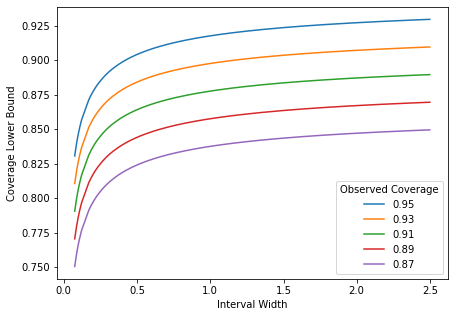

In [665]:
p_gs = np.sort(score_df["P_G"].unique())
filt = p_gs <= 0.5
plt.figure(figsize=(7,5))
t_s = score_df.groupby('boot')['score_scaled'].min().quantile(0.05)

lower_bounds = 0.95 + t_s / p_gs**(1/2)
plt.plot((p_gs * 5)[filt], lower_bounds[filt], label="0.95")

lower_bounds = 0.93 + t_s / p_gs**(1/2)
plt.plot((p_gs * 5)[filt], lower_bounds[filt], label="0.93")

lower_bounds = 0.91 + t_s / p_gs**(1/2)
plt.plot((p_gs * 5)[filt], lower_bounds[filt], label="0.91")

lower_bounds = 0.89 + t_s / p_gs**(1/2)
plt.plot((p_gs * 5)[filt], lower_bounds[filt], label="0.89")

lower_bounds = 0.87 + t_s / p_gs**(1/2)
plt.plot((p_gs * 5)[filt], lower_bounds[filt], label="0.87")
plt.xlabel("Interval Width")
plt.ylabel("Coverage Lower Bound")
plt.legend(title="Observed Coverage")
# plt.savefig("coverage_width_tradeoff.png", dpi=300)


## Certification over all sub-intervals

In [597]:
# dynamic programming algorithm to compute bootstrap infimum
def sample_score(x, coverage, certify_level):
    df = pd.DataFrame(dict(x = x.flatten(), miscoverage = ~coverage))
    df = df.sort_values(by=["x"], ignore_index = True)
    
    # resample df to get b_df
    b_idx = np.random.choice(len(df), size=len(df))
    b_df = df.iloc[b_idx]
    b_df = b_df.sort_values(by=["x"], ignore_index = True)
    b_df.columns = ["x", "miscoverage"]
        
    n_idx, b_idx = 0, 0
    phi_array = []
    while True:
        new_row = {}
        if n_idx < len(df) and (b_idx == len(b_df) or df.loc[n_idx, "x"] < b_df.loc[b_idx, "x"]):
            phi = certify_level - int(df.loc[n_idx, "miscoverage"])
            n_idx += 1
        elif b_idx < len(b_df) and (n_idx == len(df) or df.loc[n_idx, "x"] > b_df.loc[b_idx, "x"]):
            phi = int(b_df.loc[b_idx, "miscoverage"]) - certify_level
            b_idx += 1
        else:
            phi = int(b_df.loc[b_idx, "miscoverage"]) - int(df.loc[n_idx, "miscoverage"])
            n_idx += 1
            b_idx += 1
        phi_array.append(-1 * phi)
        if n_idx == len(df) and b_idx == len(b_df):
            break

    # find minimum-sum subinterval of phi_array

    def max_subarray(numbers):
        best_sum = 0  # or: float('-inf')
        current_sum = 0
        for x in numbers:
            current_sum = max(0, current_sum + x)
            best_sum = max(best_sum, current_sum)
        return best_sum

    score = max_subarray(phi_array)
    return -1 * score / len(df)

In [598]:
B = 250
certify_level = 0.15

b_scores = []
for i in tqdm(range(B)):
    b_score = sample_score(x_test, coverage, certify_level = certify_level)
    b_scores.append(b_score)

100%|██████████| 250/250 [01:15<00:00,  3.31it/s]


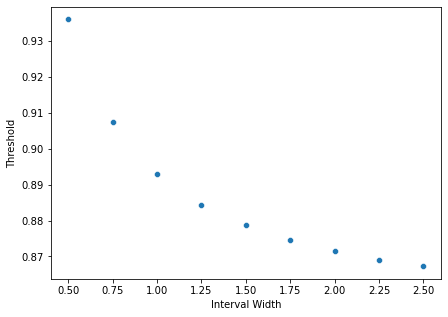

In [614]:
confidences = [0.05] #[0.01, 0.05, 0.10, 0.20]
probs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

certify_df = pd.DataFrame({"Threshold": [], "Confidence": [], f"Interval Width": []})

for c in confidences:
    for p in probs:
        row = {}
        row["Confidence"] = 1 - c
        row["Threshold"] = 1 - (certify_level) - np.quantile(b_scores, c) / p
        if row["Threshold"] > 1:
            row["Threshold"] = np.nan
        row[f"Interval Width"] = p * 5
        row[f"Probability"] = p
        certify_df = certify_df.append(row, ignore_index = True)
    
plt.figure(figsize=(7,5))
sns.scatterplot(x="Interval Width", y="Threshold", data=certify_df)
plt.savefig("threshold_certify_85.png")


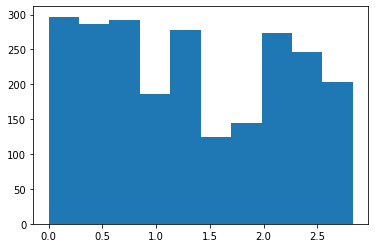

In [605]:
cover_df = pd.DataFrame(dict(x=x_test.flatten(), coverage=coverage))
cover_df = cover_df.sort_values(by=["x"]).reset_index()
min_prob = 0.2

num_window = int(min_prob * len(cover_df))

min_covers = []
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size = num_window)
cover_df["avg_coverage"] = cover_df.coverage.rolling(indexer, min_periods = num_window).mean()

threshold = certify_df.loc[certify_df["Probability"] == min_prob, "Threshold"].item()
_ = plt.hist(cover_df[cover_df["avg_coverage"] > threshold]['x'])